# **Model Development - Algeris - 90 Days**
by: Argish Abhangi

`Model info:` **120 Days** Prior data input ➡ lstm_model ➡ **90 days** ahead prediction output

Model - `LSTM` <br>
Trainig Metrics used - `MSE` <br> 
Optimizer used - `Adam` 


#### Importing Libraries

In [49]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [50]:
# Load the training and testing datasets
train_data_path = '../data/train_algiers.csv'
test_data_path = '../data/test_algiers.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,...,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,water_availability
0,2015-04-01,0.0,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.000000,0.023497,...,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155,-200.341947
1,2015-04-02,0.0,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.000000,0.032284,...,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715,-173.229781
2,2015-04-03,0.0,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.000000,0.021108,...,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284,-175.856488
3,2015-04-04,0.0,12.117507,0.006628,74.249417,-0.762048,-1.315288,11.899657,0.000000,0.022526,...,0.0,289.779312,929.087080,234.026542,4.696759,0.0,202.458474,0.000009,929.092368,-164.456208
4,2015-04-05,0.0,11.775280,0.006604,75.414558,-1.970064,-1.730378,13.397951,0.015292,0.027819,...,0.0,289.759368,926.925510,232.774424,4.638155,0.0,222.788846,0.000011,926.930220,-186.252044


In [51]:
train_data.columns

Index(['date', 'precipitation_sum (mm)', 'temperature_2m_above_ground',
       'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface',
       'ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'EvapSnow_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg',
       'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qsm_tavg', 'Qs_tavg',
       'SnowDepth_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg', 'SoilMoist_RZ_tavg',
       'SoilMoist_S_tavg', 'SWE_tavg', 'Swnet_tavg', 'TVeg_tavg', 'TWS_tavg',
       'water_availability'],
      dtype='object')

In [52]:
len(train_data.columns)

33

#### Data Transformation and Normalization

In [53]:
# Convert 'date' to datetime and set as index
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

In [54]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convert scaled data back to DataFrame for easier handling
train_scaled_df = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

In [55]:
def create_dataset(X, y, time_steps_in=1, time_steps_out=1):
    """
    Create a dataset for LSTM with specified number of input and output time steps.
    
    :param X: Input features
    :param y: Target feature
    :param time_steps_in: Number of time steps to use as input
    :param time_steps_out: Number of time steps to predict
    :return: reshaped input and output for LSTM model
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps_in - time_steps_out + 1):
        v = X.iloc[i:(i + time_steps_in)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps_in:i + time_steps_in + time_steps_out].values)
    
    return np.array(Xs), np.array(ys)

# Number of time steps for input and output
# Change time_steps_out to jump the prediction that many days ahead.
time_steps_in, time_steps_out = 110, 90

X_train, y_train = create_dataset(train_scaled_df.drop('water_availability', axis=1), train_scaled_df['water_availability'], time_steps_in, time_steps_out)
X_test, y_test = create_dataset(test_scaled_df.drop('water_availability', axis=1), test_scaled_df['water_availability'], time_steps_in, time_steps_out)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2251, 110, 31), (2251, 90), (346, 110, 31), (346, 90))

### **Model Training**

In [56]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.index

In [57]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_layer_size)
        out = self.linear(hn)
        return out

# Model parameters
input_size = 31  # Number of features
hidden_layer_size = 65  # Can be modified to optimize performance
output_size = time_steps_out  # Predicting x time steps into the future

# Instantiate the model
model = LSTMModel(input_size, hidden_layer_size, output_size)
model.to(device)

model

LSTMModel(
  (lstm): LSTM(31, 65, batch_first=True)
  (linear): Linear(in_features=65, out_features=90, bias=True)
)

In [58]:
# Training parameters
learning_rate = 0.0001
num_epochs = 400  

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [59]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# UnComment to save the model
# torch.save(model.state_dict(), './trained_model/MPIMO_LSTM_90_Days.pt')

"Model training complete and model saved."

Epoch [10/400], Loss: 0.0251
Epoch [20/400], Loss: 0.0234
Epoch [30/400], Loss: 0.0218
Epoch [40/400], Loss: 0.0203
Epoch [50/400], Loss: 0.0188
Epoch [60/400], Loss: 0.0174
Epoch [70/400], Loss: 0.0160
Epoch [80/400], Loss: 0.0146
Epoch [90/400], Loss: 0.0133
Epoch [100/400], Loss: 0.0121
Epoch [110/400], Loss: 0.0111
Epoch [120/400], Loss: 0.0103
Epoch [130/400], Loss: 0.0097
Epoch [140/400], Loss: 0.0092
Epoch [150/400], Loss: 0.0089
Epoch [160/400], Loss: 0.0087
Epoch [170/400], Loss: 0.0085
Epoch [180/400], Loss: 0.0084
Epoch [190/400], Loss: 0.0083
Epoch [200/400], Loss: 0.0082
Epoch [210/400], Loss: 0.0081
Epoch [220/400], Loss: 0.0081
Epoch [230/400], Loss: 0.0080
Epoch [240/400], Loss: 0.0080
Epoch [250/400], Loss: 0.0079
Epoch [260/400], Loss: 0.0079
Epoch [270/400], Loss: 0.0079
Epoch [280/400], Loss: 0.0078
Epoch [290/400], Loss: 0.0078
Epoch [300/400], Loss: 0.0077
Epoch [310/400], Loss: 0.0077
Epoch [320/400], Loss: 0.0077
Epoch [330/400], Loss: 0.0076
Epoch [340/400], Lo

'Model training complete and model saved.'

### **Evaluating the model**

In [60]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)

test_loss.item()

0.002925113309174776

#### Metrics before inverse transform

In [61]:
test_predictions_np = test_predictions.detach().cpu().numpy()

mse = mean_squared_error(y_test, test_predictions_np)
rmse = root_mean_squared_error(y_test, test_predictions_np)
mae = mean_absolute_error(y_test, test_predictions_np)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 0.0029
mae: 0.0409
rmse: 0.0537


#### Inverse Transforming predictions and y_test

In [62]:
num_features = train_data.shape[1] 

last_step_predictions = test_predictions.detach().cpu().numpy()[:, -1]
dummies = np.zeros((last_step_predictions.shape[0], num_features))
dummies[:, -1] = last_step_predictions
dummies_transformed = scaler.inverse_transform(dummies)
inverse_transformed_test_predictions = dummies_transformed[:, -1]

y_test_last_step = y_test[:, -1]
y_test_dummies = np.zeros((y_test.shape[0], num_features))
y_test_dummies[:, -1] = y_test_last_step
y_test_dummies_transformed = scaler.inverse_transform(y_test_dummies)
inverse_transformed_y_test = y_test_dummies_transformed[:, -1]


####  Visualizing the results

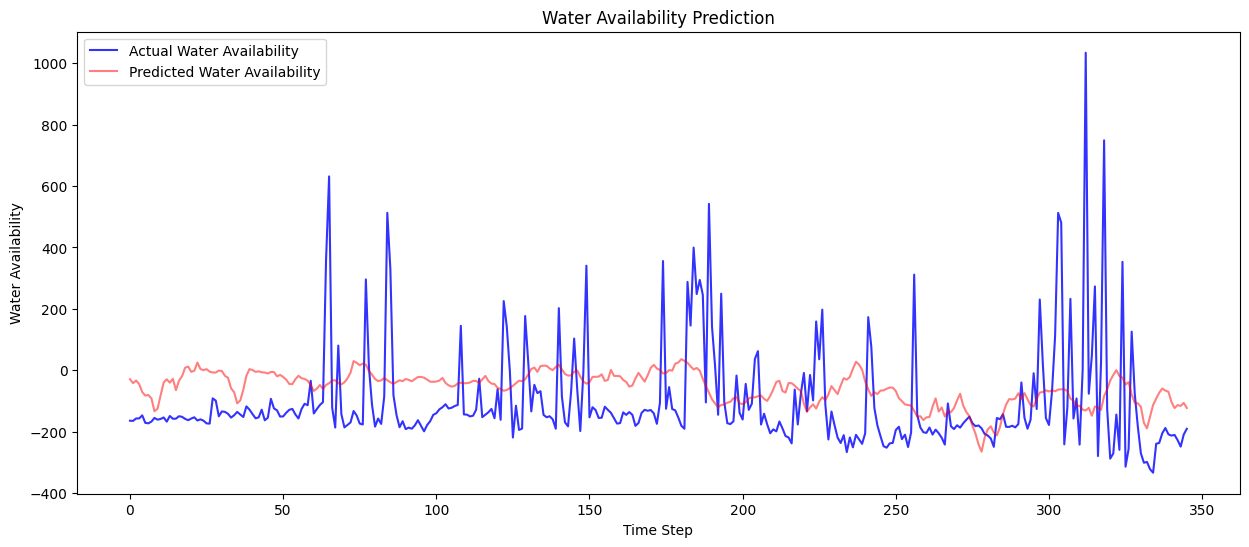

In [63]:
plt.figure(figsize=(15, 6))
plt.plot(inverse_transformed_y_test, label='Actual Water Availability', color='blue', alpha=0.8)  # Use inverse transformed data
plt.plot(inverse_transformed_test_predictions, label='Predicted Water Availability', color='red', alpha=0.5)
plt.title('Water Availability Prediction')
plt.xlabel('Time Step')
plt.ylabel('Water Availability')
plt.legend()
plt.show()

#### Metrics after inverse transform

In [64]:
mse = mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
rmse = root_mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
mae = mean_absolute_error(inverse_transformed_y_test, inverse_transformed_test_predictions)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 31940.8612
mae: 136.8677
rmse: 178.7201
